# Darren Hunt

PHYS 434AA

11-01-2020

Lab 4

In [96]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import h5py
from scipy import stats
from scipy.stats import binned_statistic

# Building a Poisson Background pdf

In [97]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))  # pull data out of file
hf.close()

In [98]:
t = data[0]  # time, GPS seconds
deg = data[1]  # solar phase, degrees
long = data[2]  # longitude, degrees
d = data[3]  # particle counts

To begin, we import the datafile and pull it out in the format of a multidimensional array. For calculation and plotting ease, I set each column equal to its own variable above. The data includes time in GPS seconds, solar phase in degrees, longitude in degrees (describing the spacecraft's position relative to the ground), and the particle counts.

For quick plotting, below are three functions written to plot a scatterplot, a 1D histogram, and 2D histogram.

In [99]:
def scatter_plotter(x,mu,title):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    plt.style.use('ggplot')
    ax.set_title(title, fontsize=24)
    ax.set_xlabel("Folded Time (s)", fontsize=20)
    ax.set_ylabel("Average Counts", fontsize=20)
    plt.tick_params(labelsize = 18)

    plt.scatter(x[:-1],mu,color='b')
    plt.show()

In [100]:
def hist_plotter(t,bins,title):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    plt.style.use('ggplot')
    ax.set_title(title, fontsize=24)
    ax.set_xlabel("Counts", fontsize=20)
    ax.set_ylabel("Frequency", fontsize=20)
    plt.tick_params(labelsize = 18)

    plt.hist(t,bins=bins,color='r')
    plt.show()

In [101]:
def hist2D_plotter(t,bg,bins,title):
    # plots a 2D histogram to show density of points in central area, user inputs number of bins
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.set_title(title, fontsize=24)
    ax.set_xlabel("Folded Time (s)" if t is tf else "Longitude (deg)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    plt.tick_params(labelsize = 18)

    plt.hist2d(t,bg,density=True,bins=bins)
    plt.colorbar()
    plt.show()

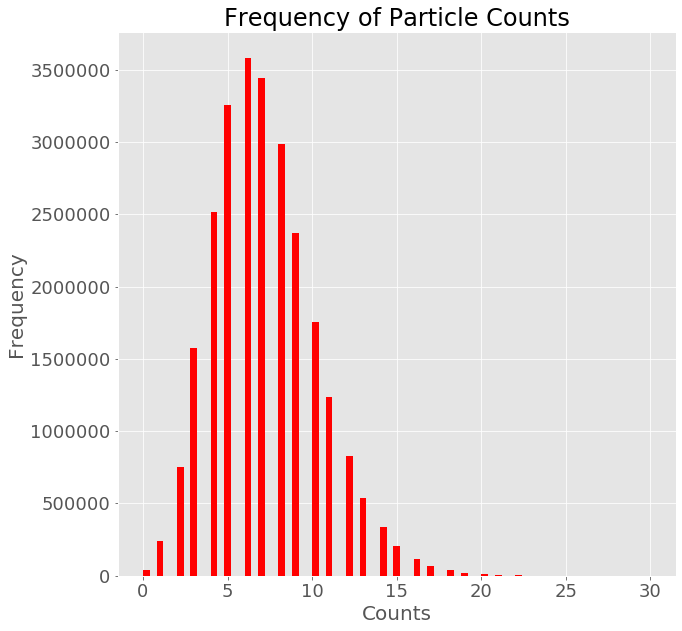

In [102]:
hist_plotter(d,75,"Frequency of Particle Counts")

This 1D histogram shows the frequency of particle counts from the dataset. This is not yet plotted as a function of time or other parameter, so we can't see how the observed particle counts varies throughout time. However, this does show us that the distribution of counts is discrete. Every 100ms, the satellite measures the observed number of counts that hits the detector. For this background, the counts are mainly cosmic ray detections. Therefore, we can say that the background pdf we construct will take on a Poisson distribution of average counts, since the counts are a discrete, integer number. However, we need to check for signal contamination (gamma ray detections) within our distribution. This is best done using a semilog plot.

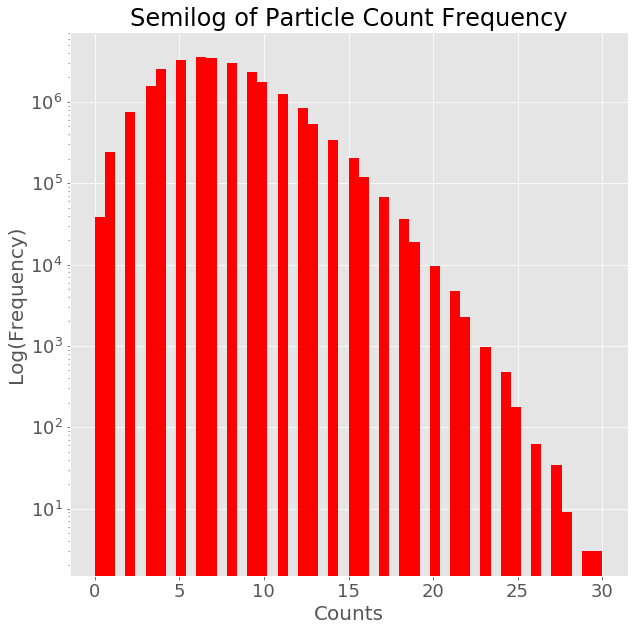

In [103]:
# plot as semilog
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.style.use('ggplot')
ax.set_title("Semilog of Particle Count Frequency", fontsize=24)
ax.set_xlabel("Counts", fontsize=20)
ax.set_ylabel("Log(Frequency)", fontsize=20)
plt.tick_params(labelsize = 18)

plt.hist(d,50,color='r')
plt.yscale('log')
plt.show()

Looking at the particle count histogram plotted as a semilog, we can the shape appears approximately discretely distributed about a mean of ~6 counts (per 100ms). The majority of points fall within this distribution. At the right tail end however, we see a very small amount of counts that may fall within a statistical outlier, or be considered signal. A 5-sigma calculation will need to be done to determine the significance, after we build a background pdf.

In [104]:
def fold_signal(t,period):
    # folds the periodic signal
    tfolded = t % (period)
    return tfolded

This function is meant to fold a periodic signal by its period in order to reveal particular patterns that the background or signal follow throughout time. Since the satellite completes an orbit every 90 minutes, the pattern should repeat at  5400 seconds. Once folded, we should be able to determine specific points in the cycle where the background changes.

In [105]:
tf = fold_signal(t,5400)

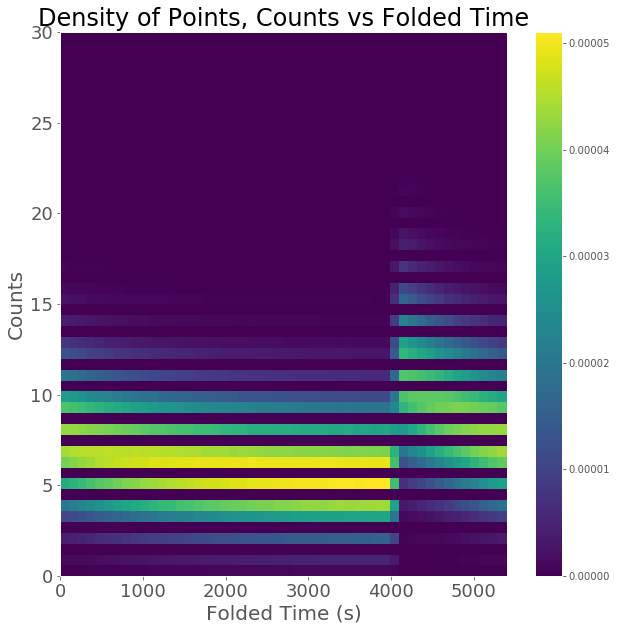

In [106]:
# counts vs folded gps time, periodic signal
hist2D_plotter(tf,d,50,"Density of Points, Counts vs Folded Time")

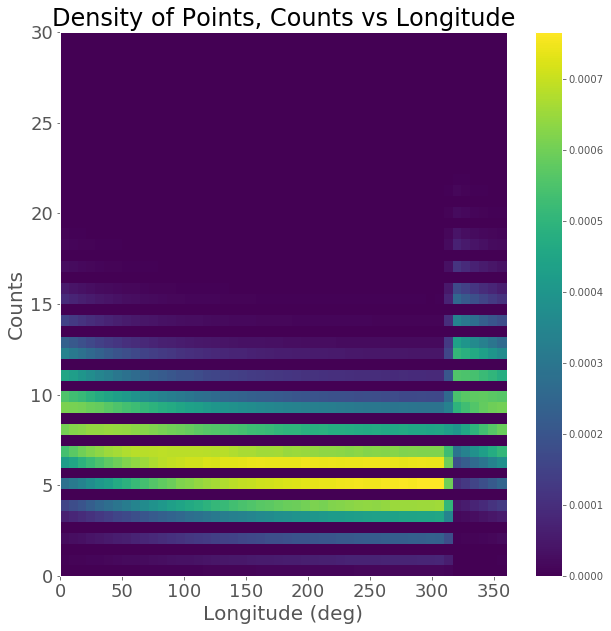

In [107]:
# counts vs longitude
hist2D_plotter(long,d,50,"Density of Points, Counts vs Longitude")

The above plots show two different representations of the background data: particle counts as a function of time (which has been folded to emphasize the periodic nature and pattern of the counts data), and particle counts as a function of longitude, describing the spacecraft's position relative to the Earth's surface (which is also cyclic, as the spacecraft orbits the Earth at a set period).

In both periodic plots, we see the same pattern demonstrated. For the majority of the cycle, the average number of particle counts hitting the detector remains about 5-6 per measurement (every 100ms). The yellow bands indicate where this is most likely to occur in the cycle (both time and longitude). There is a slight decrease in average counts in the first portion of the cycle, indicated by the green to yellow color gradient. However, there is a major change in the background around tf=4000 and longtiude=300. Here, the mean number of counts instantaneously spikes. This means the detector at this point in the cycle suddenly begins detecting more particles per measurement.

Comparing alongside the histogram of count frequency, we can see this is a likely a Poisson distribution of discrete particle count data as a background, and that the major feature to consider is the sudden change towards the end of the period. We will have to perform a 5-sigma calculation to determine the likelihood and presence of gamma ray bursts, the signal, within the cosmic ray particle background. This is the possible signal contamination that is visible in the semilog histogram.

In order to do this, we need to construct a background pdf. Since the background is not constant throughout time, we have to do this is a function of time. This involves taking the mean counts per bin of a histogram; by breaking the data up into groups and calculating one mean value per group, we can then plot the average counts as a function of time. From here, we can determine a background Poisson distribution at each point in time.

http://scipy.github.io/devdocs/generated/scipy.stats.binned_statistic.html is a built in function to calculate statistical mean per min in a dataset.

In [108]:
# build a background PDF based on above plots, start by calculating means
mu,edges,binNo = stats.binned_statistic(tf,d,statistic='mean',bins=75)

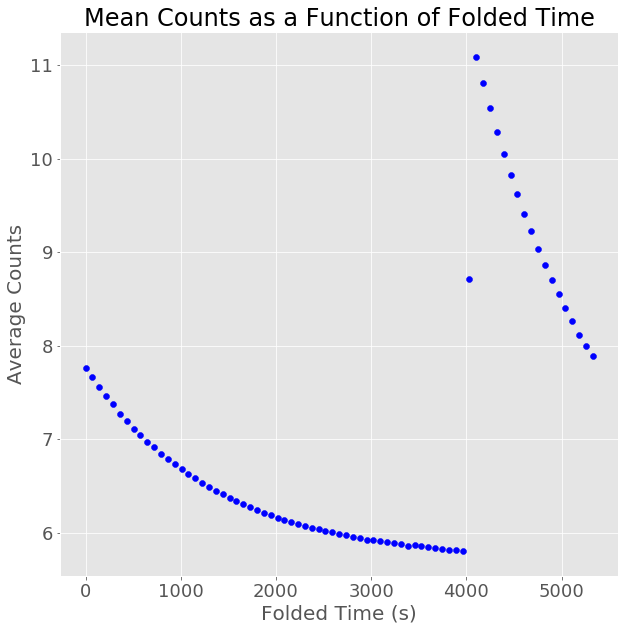

In [109]:
scatter_plotter(edges,mu,"Mean Counts as a Function of Folded Time")

This scatterplot displays the average number of particle counts as function of the periodic time we folded earlier. We can see the same trend that was demonstrated in the 2D histograms above, and clearly identify the point in time where the average counts suddenly spike up. Using this, we can now construct a background pdf that varies with time. A Poisson pmf takes in number of occurrenecs *k* and the average as parameters, and the previous calculation provided us mu which varies with time (k stays constant).

In [110]:
# Poisson pmf as a function of time. mu=average counts in each bin, k=possible discrete count vals
bkgPdf = []
k = np.arange(0,31,1)
for i in range(len(mu)):
    bkg = stats.poisson.pmf(k,mu[i])
    bkgPdf.append(bkg)
bkgPdf = np.asarray(bkgPdf)
bkgPdf.shape  # dimensions

(75, 31)

This loop creates a multidimensional array, with a Poisson pmf for each mean value in the 75 bins from the previous scatterplot. Each pmf is plotted for possible *k* values, which range from 0 to 30 for this dataset. Now, we can plot this as a Poisson distribution. Each time we plot it, we are looking at a different instance in time. It is easiest to plot a select few to demonstrate the background's dependence on time.

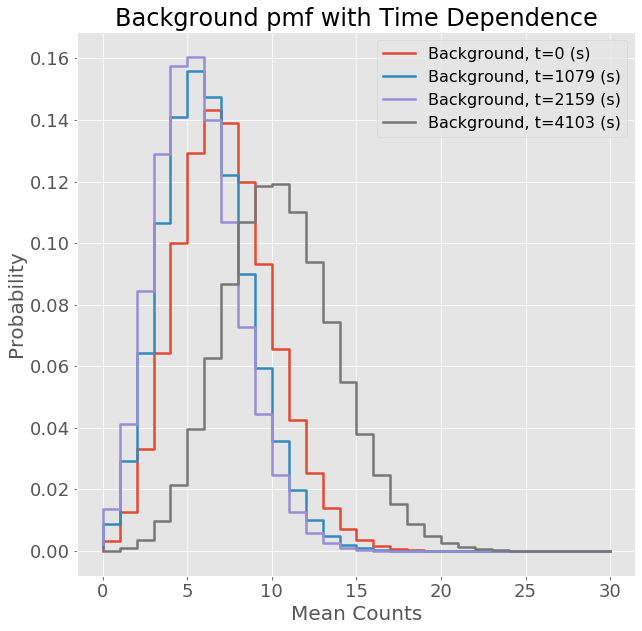

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.style.use('ggplot')
ax.set_title("Background pmf with Time Dependence", fontsize=24)
ax.set_xlabel("Mean Counts", fontsize=20)
ax.set_ylabel("Probability", fontsize=20)
plt.tick_params(labelsize = 18)

for i in range(len(mu)):
    if i==0 or i==15 or i==30 or i==57:  # plot a few different bkg Poissons in time
        ax.step(k,bkgPdf[i],linewidth=2.5,label="Background, t="+str(int(edges[i]))+" (s)")
        # edges var gives us the time axis from the bin which the mean was calculated
    else: pass
    
plt.legend(fontsize=16,loc='best')
plt.show()

This plot shows the background pmf, a Poisson, at different points in time. Since the Poisson takes in a varying mean, which was previously calculated as a function of time, this background model is time dependent. We can clearly see that the beginning of the cycle (corresponding to my 2D histograms earlier) is different from points in the middle, and that at about 4100s the background distribution shifts, which we expected after examining the 2D histograms. The background for t=4103s has a significantly different mean counts value and corresponding probability than the background at about t=1000s. Additionally, the right tail of the distribution trails out farther along the counts axis. The background is entirely shifted and has an altered shape.

In [112]:
# real data. the k values cut off earlier in this range but hold a mean of 6.
rl = stats.poisson.pmf(k[0:15],6)

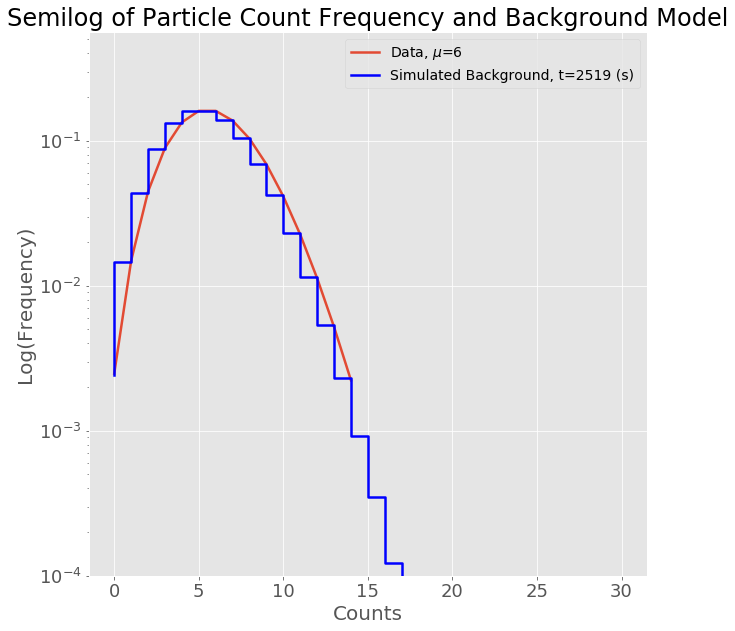

In [113]:
# compare model to the raw data: plot as semilog
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.style.use('ggplot')
ax.set_title("Semilog of Particle Count Frequency and Background Model", fontsize=24)
ax.set_xlabel("Counts", fontsize=20)
ax.set_ylabel("Log(Frequency)", fontsize=20)
plt.tick_params(labelsize = 18)

# must plot the raw data within range relevant to the Poisson. the counts data
# changes throughout time and corresponds to a Poisson per bin.
start, end = int(edges[35]), int(edges[36])  # to splice array
ax.plot(k[0:15],rl,linewidth=2.5,label="Data, $\mu$=6")
plt.step(k,bkgPdf[35],linewidth=2.5,label="Simulated Background, t="+str(int(edges[35]))+" (s)",color='b')
plt.yscale('log')
ax.set_ylim(10e-5,None)

plt.legend(fontsize=14,loc='best')
plt.show()

This is a semilog plot of the built Poisson pmf with its time dependence (selected at a specific time) plotted alongside an estimated curve for the data within the same time range. We can see the model fits well.

Since the background varies as a function of time, the sensitivity threshold for discovery is also time dependent. The 5-sigma threshold for a signal detection of a gamma ray burst (GRB) will depend on the background and resultant statistical calculations. Therefore, we can apply the percent point function and cumulative distribution functions to answer the following statistical question:

For a discrete Poisson-distributed background with a mean that is time variant, how many particles must the satellite detect in a given 100ms observation in order to be a 5-sigma signifiance gamma ray burst detection? (The answer will be time dependent.)

In [114]:
def counts(i):
    # i=bin number. this is an index that the average mu takes.
    p = stats.norm.cdf(5)  # 5-sigma detection
    signal = stats.poisson.ppf(p,mu[i])  # invert to find number of counts required for 5-sigma detection
    return signal

In [115]:
# look at some count vals at different times for 5-sigma using the above fxn
print("Counts, 5-sigma detection for t(sec) = " + str(int(edges[5])) + ": " + str(counts(5)))
print("Counts, 5-sigma detection for t(sec) = " + str(int(edges[35])) + ": " + str(counts(35)))
print("Counts, 5-sigma detection for t(sec) = " + str(int(edges[57])) + ": " + str(counts(57)))
print("Counts, 5-sigma detection for t(sec) = " + str(int(edges[60])) + ": " + str(counts(60)))
print("Counts, 5-sigma detection for t(sec) = " + str(int(edges[74])) + ": " + str(counts(74)))

Counts, 5-sigma detection for t(sec) = 359: 24.0
Counts, 5-sigma detection for t(sec) = 2519: 22.0
Counts, 5-sigma detection for t(sec) = 4103: 31.0
Counts, 5-sigma detection for t(sec) = 4319: 30.0
Counts, 5-sigma detection for t(sec) = 5327: 25.0


This answers the previous statistical question, for various points in time. The times listed are folded. Evidently, the 5-sigma threshold greatly changes as the background varies throughout time. The amount of particle counts required to be considered a detection of a gamma ray burst must be much higher at the point in the cycle where there is a sudden spike/change (see the 2D histograms from the beginning of this lab, at about 4000s or a longitude of around 300 degrees), especially when compared to other times in the cycle where the background distribution is more consistent with an average mean of 6. With those backgroud pdfs, we require a lower threshold for a 5-sigma detection, at about 22-24 counts.

According to the following research paper https://link.springer.com/article/10.1007/s10686-012-9313-2 (Zhao et. al 2012), albedo (reflectivity of light) of the Earth's surface is a contributor to the changing background for a gamma ray detector. The percentage of light reflected back is dependent on Sun-Earth and Earth-Spacecraft orientations/angles. Therefore, a physical model could also take the solar phase into account with longitude and examine this relation.

# Building a Background for Transients

In [116]:
# grab the image data
im = h5py.File('images.h5', 'r')
im1 = np.array(im.get('image1'))
imdata = np.array(im.get('imagestack'))  # pull data out of file
im.close()

The above data we just imported is a stack of 10 square images, 200x200 pixels. We can plot this to see the image of the simulated star data. We are looking for a transient like a supernovae, which will appear as a very quick but statistically signifiant event appearing in only ~1 image of the stack.

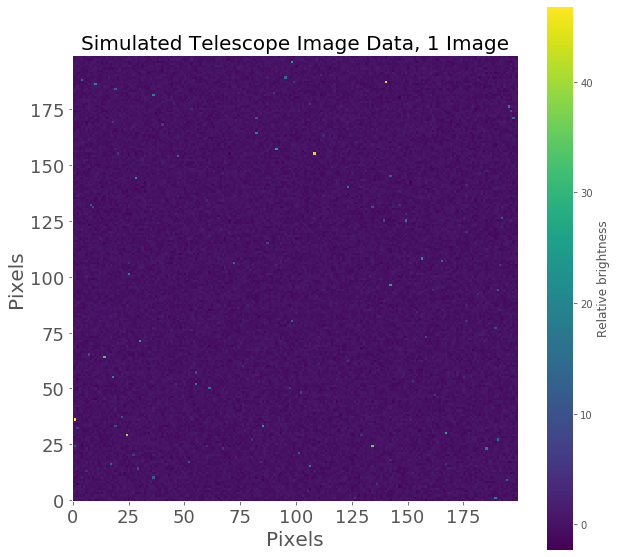

In [117]:
# plot one img
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.grid(False)
ax.set_title("Simulated Telescope Image Data, 1 Image", fontsize=20)
ax.set_xlabel("Pixels", fontsize=20)
ax.set_ylabel("Pixels", fontsize=20)
plt.tick_params(labelsize = 18)

plt.imshow(im1,origin='lower')
plt.colorbar(label='Relative brightness')
plt.show()

This plot displays the first image of the stack. The colorbar indicates the relative brightness of objects and the background sky, assumed here to be simulated stars. If we are to look for a transient within the full stack of images, we first want to find the background pdf of the sky. Then, we will search for a statistically significant signal that appears brighter than the background pdf for only one image.

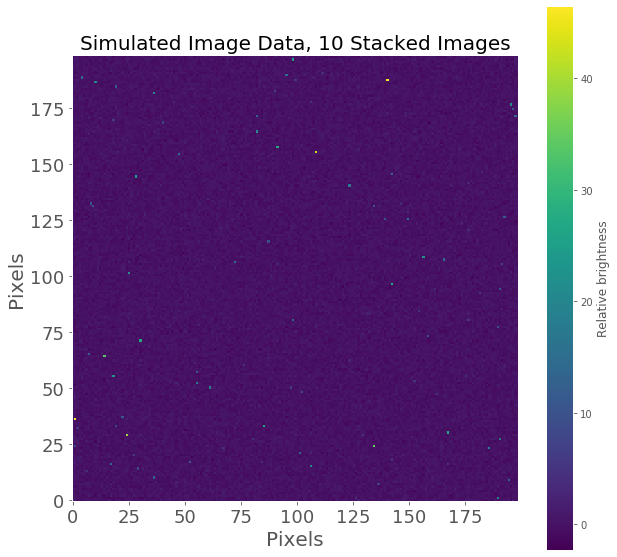

In [118]:
# plot the full img stack
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.grid(False)
ax.set_title("Simulated Image Data, 10 Stacked Images", fontsize=20)
ax.set_xlabel("Pixels", fontsize=20)
ax.set_ylabel("Pixels", fontsize=20)
plt.tick_params(labelsize = 18)

for i in range(0,9):
    plt.imshow(imdata[0:199,0:199,i], origin='lower')
plt.colorbar(label='Relative brightness')
plt.show()

Comparing the single image (one frozen moment of data from the sky) to the full image stack shows us there is not a time dependence on the background. The only feature that could have a time dependence would be the transient itself that we are looking for (since it only occurs at one moment in time). The background itself is relatively unchanging. Additionally, it is mostly spatially consistent. There are only tiny differences between the single image and the stack, which tells us not much has changed over the course of the night the images are taken/simulated. It is difficult to determine anything major by just examining with the naked eye, however. 

The field we are looking at in the sky then is stable and consistent, as well as predictable.

There is signal contamination to consider, however. The point features of significant brightness are likely stars, remaining mostly predictable and consistent with small variations due to the atmosphere. Otherwise, the main feature we must look for is a significant change in one image that is not attributable to the background pdf.

Therefore, we can ask the following statistical question to solve this problem:

For a time-independent sky background pdf, what is the probability we observe a statistically significant transient event occur in at least one of the images?

In order to solve this question, we must determine the background distribution of the sky. We also need take into account the expected relative brightnesses of the regular stars that appear in the images. A transient event will be significantly brighter than the dark sky and will only show up in one image.

In [119]:
# build background pdf: average night sky
skyMu, skyStd = [], []
for i in range(0,9):
    mean, std = stats.norm.fit(imdata[0:199,0:199,i])
    skyMu.append(mean), skyStd.append(std)

In [123]:
# find differences btwn signal
for i in range(0,8):
    diff = imdata[0:199,0:199,i+1] - imdata[0:199,0:199,i]  # change in signal between two consecutive imgs

In [124]:
# look for transient within each img
for i in range(0,9):
    cdf = stats.norm(loc=skyMu[i],scale=skyStd[i]).cdf(5)  # each img has its own pdf.
    #p = 1-cdf  # probabilities for each img
    #sg = stats.norm.ppf(cdf)
    #print(1-sg)